In [283]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Random Forest

## Load data

In [284]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/clean/aligned_data', f"merged_dataset_{well_filter}.csv")
df = pd.read_csv(path)
len(df)

192

## Sort by date

In [285]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

## Remove some columns and rows

--> By dropping Nan we exclude nitrate points that fall under city areas

In [286]:
df = df.drop(columns=['soil region', 'landuse code'])

df = df.dropna()
len(df)

132

## Add month and year as a feature

In [287]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Change column type

In [288]:
for col in ['soil region', 'landuse code', 'soilunit_code_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [289]:
df.dtypes

bro-id                                 object
nitrate                               float64
geometry                               object
date                      datetime64[ns, UTC]
population                            float64
groundwater depth                     float64
elevation                             float64
lon                                   float64
lat                                   float64
precipitation                         float64
temperature                           float64
n deposition                          float64
soilunit_code_1                      category
organicmattercontent_1                float64
density_1                             float64
acidity_1                             float64
month                                   int32
year                                    int32
dtype: object

## Remove nitrate outliers

<Axes: >

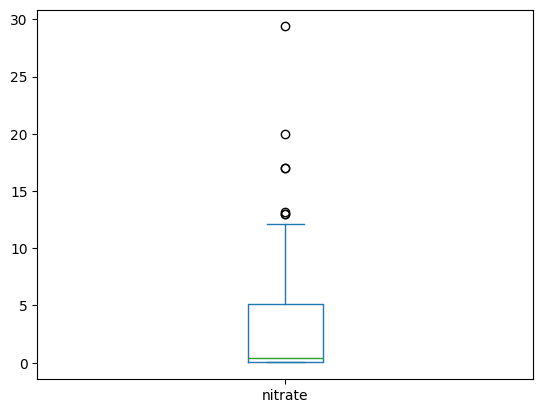

In [290]:
df[["nitrate"]].plot(kind = "box")

In [291]:
q1 = df["nitrate"].quantile(0.25)
q3 = df["nitrate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["nitrate"] < lower_bound) | (df["nitrate"] > upper_bound)]
print(f"Outliers found: {len(outliers)}")
outliers

Outliers found: 7


,bro-id,nitrate,geometry,date,population,groundwater depth,elevation,lon,lat,precipitation,temperature,n deposition,soilunit_code_1,organicmattercontent_1,density_1,acidity_1,month,year
1,GAR000000000784,29.37,POINT (5.600793941 51.962453539),2012-02-23 10:00:00+00:00,40.0,6.838178,12.048532,5.600794,51.962454,8.75,29.466667,27.383685,bEZ30,2.0,1.425,4.5,2,2012
33,GAR000000000826,13.17,POINT (5.580385464 51.97882674),2012-04-05 10:00:00+00:00,10.0,9.198382,8.355708,5.580385,51.978827,1.75,59.083333,23.433711,pZg21,5.5,1.368,4.8,4,2012
78,GAR000000000785,20.00,POINT (5.600793941 51.962453539),2015-06-16 10:00:00+00:00,35.0,6.634271,12.048532,5.600794,51.962454,1.00,125.166667,25.198593,bEZ30,2.0,1.425,4.5,6,2015
79,GAR000000000827,13.00,POINT (5.580385464 51.97882674),2015-06-16 10:00:00+00:00,15.0,9.296806,8.355708,5.580385,51.978827,1.00,125.166667,21.654822,pZg21,5.5,1.368,4.8,6,2015
103,GAR000000000818,13.00,POINT (5.54652435 51.966979885),2015-07-15 10:00:00+00:00,50.0,9.229444,16.680454,5.546524,51.966980,27.50,157.633333,26.025006,bEZ30,2.0,1.425,4.5,7,2015
147,GAR000000000786,17.00,POINT (5.600793941 51.962453539),2018-05-18 10:00:00+00:00,40.0,6.654944,12.048532,5.600794,51.962454,0.25,115.566667,25.716852,bEZ30,2.0,1.425,4.5,5,2018
163,GAR000000000819,17.00,POINT (5.54652435 51.966979885),2018-05-28 10:00:00+00:00,55.0,9.291444,16.680454,5.546524,51.966980,6.00,137.700000,28.616301,bEZ30,2.0,1.425,4.5,5,2018


In [292]:
# top_nitrate_outliers = list(df["nitrate"].sort_values()[-len(outliers):].index)
# top_nitrate_outliers
# df = df.drop(top_nitrate_outliers)
# len(df)

## Test / train split

In [293]:
df["nitrate"] = np.log1p(df["nitrate"])

In [294]:
train_df = df[df["year"].isin([2012, 2013, 2014, 2015, 2016, 2017])]
test_df  = df[df["year"].isin([2018, 2019, 2020])]

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"])
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"])
y_test = test_df["nitrate"]

Train: 84
Test: 48


## Preprocess data

In [295]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [296]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['soilunit_code_1']
Numerical: ['population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1']
All X_train columns: ['population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'soilunit_code_1', 'organicmattercontent_1', 'density_1', 'acidity_1']


In [297]:
# preprocessor = ColumnTransformer([
#     ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
# ], remainder="passthrough")

preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num_scaler", StandardScaler(), numerical_cols)
])

## Initialize model

In [298]:
rf_model = RandomForestRegressor(random_state=4, oob_score=True)

In [299]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("rf", rf_model)
])

In [300]:
param_grid = {
    "rf__n_estimators": [100, 150, 200],
    "rf__max_features": ["sqrt", 0.5, 1],
    "rf__max_depth": [None, 10],
    "rf__min_samples_split": [2, 4, 6],
    "rf__min_samples_leaf": [1, 2]
}

## Hyperparameter tuning

In [301]:
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_grid,
    n_iter=30,
    cv=tscv,
    scoring="r2",
    n_jobs=-1,
    random_state=9,
    verbose=1
)
search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('cat_ohe',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['soilunit_code_1']),
                                                                              ('num_scaler',
                                                                               StandardScaler(),
                                                                               ['population',
                                                                                'groundwater '
                                                                                'depth',
                                                                                'elevation',
                                                                                'precipitation',
                                                                                'tempera...
                                                                                'organicmattercontent_1',
                                                                                'density_1',
                                                                                'acidity_1'])])),
                                             ('rf',
                                              RandomForestRegressor(oob_score=True,
                                                                    random_state=4))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'rf__max_depth': [None, 10],
                                        'rf__max_features': ['sqrt', 0.5, 1],
                                        'rf__min_samples_leaf': [1, 2],
                                        'rf__min_samples_split': [2, 4, 6],
                                        'rf__n_estimators': [100, 150, 200]},
                   random_state=9, scoring='r2', verbose=1)

## Train score

In [302]:
pred_train = search.predict(X_train)
print("Train R2:", r2_score(np.expm1(y_train), np.expm1(pred_train)))
print("Train MAE:", mean_absolute_error(np.expm1(y_train), np.expm1(pred_train)))
print("Test RMSE:", sqrt(mean_squared_error(np.expm1(y_train), np.expm1(pred_train))))

Train R2: 0.8798332185709257
Train MAE: 0.7956426269655488
Test RMSE: 1.800189702237288


## Test score

In [303]:
pred_nitrate = search.predict(X_test)

print("Best CV R2:", search.best_score_)
print("Best params:", search.best_params_)
print("OOB score:", search.best_estimator_.named_steps["rf"].oob_score_)
print("\n")

print("Test R2:", r2_score(np.expm1(y_test),  np.expm1(pred_nitrate)))
print("Test MAE:",mean_absolute_error(np.expm1(y_test), np.expm1(pred_nitrate)))
print("Test RMSE:", sqrt(mean_squared_error(np.expm1(y_test), np.expm1(pred_nitrate))))

Best CV R2: 0.6028422354582859
Best params: {'rf__n_estimators': 100, 'rf__min_samples_split': 4, 'rf__min_samples_leaf': 1, 'rf__max_features': 0.5, 'rf__max_depth': None}
OOB score: 0.8039791251493126


Test R2: 0.788017889969499
Test MAE: 1.0678840606334548
Test RMSE: 1.8243293097913151


## Real vs Predicted

<Axes: xlabel='nitrate', ylabel='nitrate'>

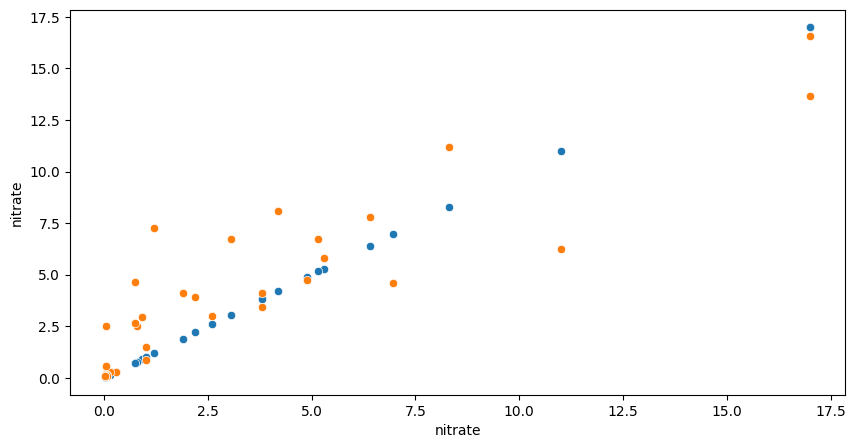

In [304]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = np.expm1(y_test), y = np.expm1(y_test), ax = ax)
sns.scatterplot(x = np.expm1(y_test), y = np.expm1(pred_nitrate), ax = ax)

## Residuals

Text(0, 0.5, 'Residuals')

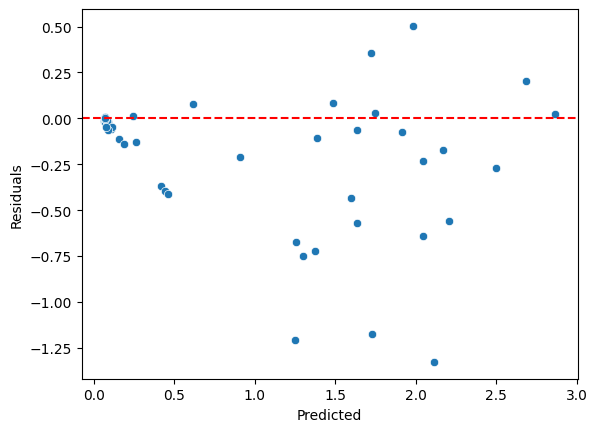

In [305]:
preds = search.predict(X_test)
residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")

## Feature importances

--> Gain (by default) how much each feature, on average, reduces the impurity (MSE or Gini)

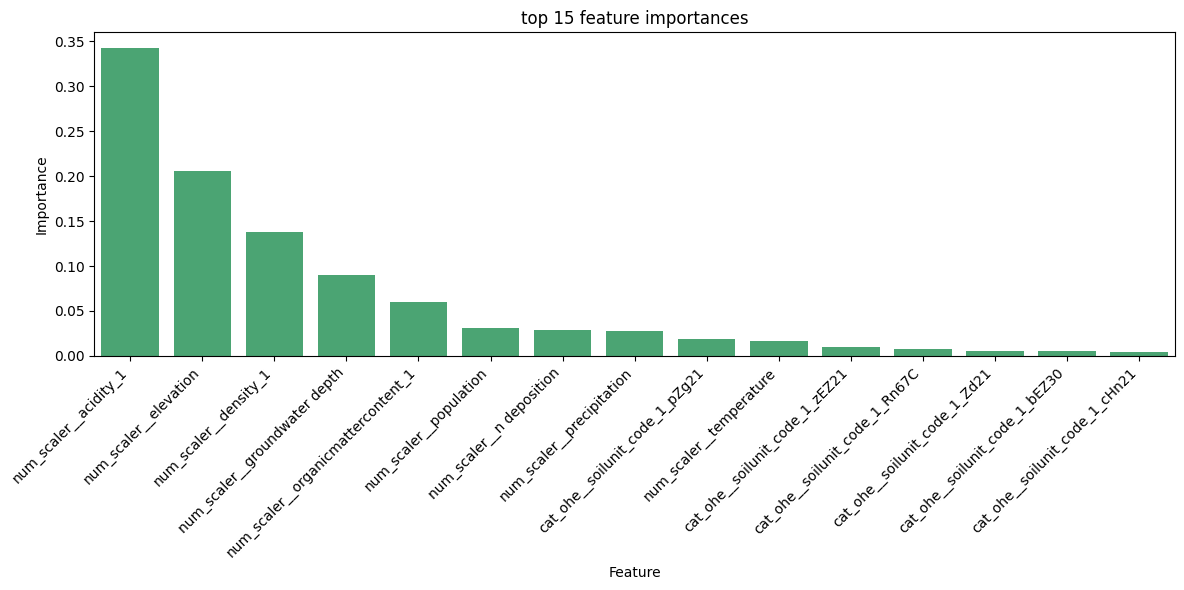

In [306]:
best_pipe = search.best_estimator_

feature_names = best_pipe.named_steps["prep"].get_feature_names_out()

rf_model = best_pipe.named_steps["rf"]
importances = rf_model.feature_importances_

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="Feature", y="Importance", data=fi_df.head(15), color="mediumseagreen")
plt.xticks(rotation=45, ha='right')
plt.title("top 15 feature importances")
plt.tight_layout()
plt.show()

In [307]:
# --- Keep:
# organiccontent
# elevation
# soil code
# acidity
# groundwater depth
# density
# population
# precipitation
# n_deposition
# temperature

# --- Remove:
# landuse
# soil region
# month